# William Fisher DATA 22100 Midterm Project

This notebook includes code for the non-vectorised Multinomial Naive Bayes classifier and for analyzing word frequency in the entire dataset.

In [1]:
import pandas as pd
import numpy as np
import io
import pickle
import re
import string

import nltk

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.utils.extmath import randomized_svd
from sklearn import metrics

plt.style.use("default")
params = {"axes.labelsize": 20, "axes.titlesize": 20,\
          "font.size": 20, "legend.fontsize": 20,\
          "xtick.labelsize": 20, "ytick.labelsize": 20,\
          "xtick.major.width": 3, 'xtick.major.size':10,\
          "ytick.major.width": 3, 'ytick.major.size':10,\
          "savefig.bbox": "tight", "savefig.dpi": 600, 'savefig.format': 'png'}
plt.rcParams.update(params)

Data is from https://botometer.osome.iu.edu/bot-repository/datasets.html <br>
cresci-2017

**Goal:** Build a Multinomial Naive Bayes to predict bot Twitter accounts. Only using word frquency in tweets.

## Read in data

In [2]:
# Genuine accounts
df_open = io.open("cresci-2017.csv/datasets_full.csv/genuine_accounts.csv/tweets.csv", encoding='latin-1')
columns = pd.read_csv(df_open, nrows=0).columns
human_df = pd.read_csv(df_open, header = None, names = columns)
human_df["bot_or_not"] = "human"

/Users/alancooper/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
human_df.shape

(2838679, 26)

In [4]:
human_df.head(5)

,id,text,source,user_id,truncated,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,retweeted_status_id,geo,...,retweeted,possibly_sensitive,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,bot_or_not
0,"Mar 19 20:59:26 +0000 2015""",2015-03-19 21:59:26,2015-05-01 12:57:19,2015-05-01 12:57:19,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,human
1,578656013127163905,@debs @kevinmarks @TummelVision this is report...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",678033,NaN,5.786542e+17,1.184800e+04,debs,0.0,NaN,...,NaN,NaN,0.0,0.0,3.0,Thu Mar 19 20:35:19 +0000 2015,2015-03-19 21:35:19,2015-05-01 12:57:19,2015-05-01 12:57:19,human
2,578654044840919040,@ThreemaApp Apple App store not downloading Th...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",678033,NaN,0.000000e+00,1.057394e+09,ThreemaApp,0.0,NaN,...,NaN,NaN,0.0,0.0,1.0,Thu Mar 19 20:27:29 +0000 2015,2015-03-19 21:27:29,2015-05-01 12:57:19,2015-05-01 12:57:19,human
3,578653741022326784,"@debs @kevinmarks @TummelVision ""itâs hard t...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",678033,NaN,5.786348e+17,1.184800e+04,debs,0.0,NaN,...,NaN,NaN,0.0,0.0,3.0,Thu Mar 19 20:26:17 +0000 2015,2015-03-19 21:26:17,2015-05-01 12:57:19,2015-05-01 12:57:19,human
4,578652979353485312,MT @MelissaFPayne Breaking: The body of an A...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",678033,NaN,0.000000e+00,0.000000e+00,NaN,0.0,NaN,...,NaN,NaN,0.0,0.0,1.0,Thu Mar 19 20:23:15 +0000 2015,2015-03-19 21:23:15,2015-05-01 12:57:19,2015-05-01 12:57:19,human


In [5]:
# Bots
df_open = io.open("cresci-2017.csv/datasets_full.csv/traditional_spambots_1.csv/tweets.csv", encoding='latin-1')
columns = pd.read_csv(df_open, nrows=0).columns
spambots_df = pd.read_csv(df_open, header = None, names = columns)

spambots_df["bot_or_not"] = "bot"

/Users/alancooper/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
spambots_df.shape

(144198, 26)

In [7]:
spambots_df.head()

,id,text,source,user_id,truncated,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,retweeted_status_id,geo,...,retweeted,possibly_sensitive,num_hashtags,num_urls,num_mentions,created_at,timestamp,crawled_at,updated,bot_or_not
0,"2014-04-16 23:57:18""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bot
1,2467956552,Find Highlights of Indian Union Budget 2003-04...,web,7248952.0,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,1.0,0.0,1246704477000L,2009-07-04 12:47:57,0000-00-00 00:00:00,2014-04-16 23:57:18,bot
2,2467839228,Find Highlights of Indian Union Budget 2003-04...,"<a href=""http://www.ping.fm/"" rel=""nofollow"">P...",7248952.0,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,1.0,0.0,1246703253000L,2009-07-04 12:27:33,0000-00-00 00:00:00,2014-04-16 23:57:18,bot
3,2467838129,The Climate Change Truth http://ping.fm/LM2NC,"<a href=""http://www.ping.fm/"" rel=""nofollow"">P...",7248952.0,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,1.0,0.0,1246703241000L,2009-07-04 12:27:21,0000-00-00 00:00:00,2014-04-16 23:57:18,bot
4,2467831867,Find Highlights of Indian Union Budget 2002-03...,"<a href=""http://www.ping.fm/"" rel=""nofollow"">P...",7248952.0,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,0.0,1.0,0.0,1246703174000L,2009-07-04 12:26:14,0000-00-00 00:00:00,2014-04-16 23:57:18,bot


In [8]:
# Combine
cols_of_interest = ["id", "user_id", "text", "bot_or_not"]
bots_df = pd.concat([spambots_df[cols_of_interest], human_df[cols_of_interest]])

In [9]:
del human_df
del spambots_df

In [10]:
# Remove entries with NULL text and user_id
bots_df = bots_df.loc[bots_df["text"].notnull() & bots_df["user_id"].notnull()]

In [11]:
bots_df.groupby("bot_or_not")["user_id"].nunique()

bot_or_not
bot      1000
human    1085
Name: user_id, dtype: int64

In [12]:
# Write out
bots_df.to_csv("bots_by_tweet_df.csv", index = False)

In [13]:
bots_df = pd.read_csv("bots_by_tweet_df.csv")

/Users/alancooper/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
# Condense by user
bots_df = bots_df.groupby(by = "user_id").agg(lambda x: x.unique()).reset_index()
# bots_df["user_id"] = bots_df.index()

# Convert tweet column from list to text
bots_df["text"] = bots_df["text"].apply(lambda x: ''.join(x))

In [15]:
bots_df.head()

,user_id,id,text,bot_or_not
0,6775342,"[592875544783499265, 591661546419302402, 58965...",I don't need an Emmy to tell me @TheTalk_CBS i...,human
1,6834152,"[593996183095218178, 593995834443763712, 59399...",I hate how California Alternative energy prett...,human
2,7004532,"[594049007309066240, 594046498741964800, 59404...",@TrevorBoris looking like an orchestra conduct...,human
3,7248952.0,"[2467956552, 2467839228, 2467838129, 246783186...",Find Highlights of Indian Union Budget 2003-04...,bot
4,7732472.0,"[29608140071, 29556617005, 29507452649, 294080...",Offline Marketing Report \u2013 How To Get Ins...,bot


In [16]:
bots_df.to_csv("bots_by_user_df_raw.csv", index = False)

In [17]:
bots_df = pd.read_csv("bots_by_user_df_raw.csv")

## Pre-processing

### Remove select characters

In [18]:
entity_prefixes = ['@','#']
def preprocess_text(text):
    '''Remove links and select special characters.
    Fixes encoding to be ASCII'''
    
    # https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression 
    def strip_links(text):
        link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
        links = re.findall(link_regex, text)
        
        for link in links:
            text = text.replace(link[0], ', ')   
        return text
    
    
    # From https://gist.github.com/tushortz/9fbde5d023c0a0204333267840b592f9
    def fix_unicode(text):

        text = (text.
            replace('\\xe2\\x80\\x99', "'").
            replace('\\xc3\\xa9', 'e').
            replace('\\xe2\\x80\\x90', '-').
            replace('\\xe2\\x80\\x91', '-').
            replace('\\xe2\\x80\\x92', '-').
            replace('\\xe2\\x80\\x93', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x98', "'").
            replace('\\xe2\\x80\\x9b', "'").
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9d', '"').
            replace('\\xe2\\x80\\x9e', '"').
            replace('\\xe2\\x80\\x9f', '"').
            replace('\\xe2\\x80\\xa6', '...').#
            replace('\\xe2\\x80\\xb2', "'").
            replace('\\xe2\\x80\\xb3', "'").
            replace('\\xe2\\x80\\xb4', "'").
            replace('\\xe2\\x80\\xb5', "'").
            replace('\\xe2\\x80\\xb6', "'").
            replace('\\xe2\\x80\\xb7', "'").
            replace('\\xe2\\x81\\xba', "+").
            replace('\\xe2\\x81\\xbb', "-").
            replace('\\xe2\\x81\\xbc', "=").
            replace('\\xe2\\x81\\xbd', "(").
            replace('\\xe2\\x81\\xbe', ")")

                     )
        return text
    
    def remove_other_unicode(text):
        regex = re.compile(r'u0e[0-9]+|xe[0-9]+|xf[0-9]+|xa[0-9]+')
        to_remove = re.findall(regex, text)
        
        for i in to_remove:
            text = text.replace(i, ', ')   
        return text

     
    def strip_all_entities(text):
        for separator in string.punctuation:
            if separator not in entity_prefixes:
                text = text.replace(separator,' ')
                words = []
        for word in text.split():
            word = word.strip()
            if word:
                if word[0] not in entity_prefixes:
                    words.append(word)
        return ' '.join(words)
    
    text = fix_unicode(text.encode("ascii","ignore").decode("ascii"))
    text = remove_other_unicode(text)
    text = strip_links(text)
    text = strip_all_entities(text)
    
    return(text)


In [19]:
filtered_text = bots_df.apply(lambda x: preprocess_text(x["text"]), axis=1)

In [20]:
bots_df["text"] = filtered_text.values

In [21]:
bots_df.to_csv("bots_by_user_df.csv", index = False)

In [22]:
bots_df = pd.read_csv("bots_by_user_df.csv")

### Tokenization

In [23]:
%%time
bots_text = bots_df.loc[bots_df["bot_or_not"]=="bot"]["text"].str.cat()
humans_text = bots_df.loc[bots_df["bot_or_not"]=="human"]["text"].str.cat()


bots_freq = nltk.FreqDist(nltk.word_tokenize(bots_text))
humans_freq = nltk.FreqDist(nltk.word_tokenize(humans_text))

CPU times: user 1min 33s, sys: 1.97 s, total: 1min 35s
Wall time: 1min 36s


In [24]:
bots_freq

FreqDist({'a': 22234, 'o': 17595, 'to': 15740, 'de': 13014, 'the': 12101, 'e': 9480, 'of': 8771, 'followers': 8598, '@': 8596, 'and': 7503, ...})

In [25]:
with open('bots_freq.pkl', 'wb') as f:
    pickle.dump(bots_freq, f)
    
with open('humans_freq.pkl', 'wb') as f:
    pickle.dump(humans_freq, f)

In [26]:
with open('bots_freq.pkl', 'rb') as f:
    bots_freq = pickle.load(f)

with open('humans_freq.pkl', 'rb') as f:
      humans_freq = pickle.load(f)

In [27]:
humans_freq

FreqDist({'the': 607616, 'I': 594501, 'to': 545430, 'a': 462872, 'you': 376249, 'and': 308033, 'RT': 304313, '@': 297241, 'in': 294595, 'is': 290999, ...})

In [28]:
humans_text[1:100]

' don t need an Emmy to tell me CBS is the best daytime talk show hands down Love the ladies of The '

In [29]:
words_to_remove = ["@", "#"]

In [30]:
dict_filter = lambda word_dict: dict( (word, word_dict[word]) for word in word_dict if (word_dict[word] > 0.001*word_dict.N() and word not in words_to_remove))
bots_filt = dict_filter(bots_freq)
humans_filt = dict_filter(humans_freq)

In [31]:
filt_tokens = list(humans_filt.keys())
filt_tokens.extend(list(bots_filt.keys()))

In [32]:
all_tokens = list(humans_freq.keys())
all_tokens.extend(list(bots_freq.keys()))

In [33]:
filt_tokens = pd.Series(filt_tokens).unique()

In [34]:
len(filt_tokens)

175

In [35]:
filt_tokens

array(['the', 'I', 'to', 'a', 'you', 'and', 'RT', 'in', 'is', 'of', 's',
       'for', 'it', 't', 'my', 'on', 'that', 'me', 'this', 'be', 'with',
       'at', 'm', 'so', 'have', 'are', 'like', 'your', 'just', 'not',
       'was', 'can', 'but', 'i', 'all', 'up', 'out', 'amp', 'from', 'The',
       'get', 'do', 'co', 'we', 'what', 'about', 'no', 'don', 'when',
       'one', 'na', 'they', 'if', 'love', 'will', 'as', 're', 'know',
       'by', 'he', 'now', 'people', 'de', 'time', 'an', 'or', 'good',
       'day', 'go', 'who', 'how', 'has', 'want', 'It', 'got', 'You',
       'more', 'A', 'too', 'today', '2', 'see', 'there', 'think', '3',
       'u', 'need', 'new', 'really', 'some', 'll', 'his', 'back', 'much',
       'would', 'going', 've', 'make', 'been', 'them', 'right', 'que',
       'her', 'still', 'via', 'here', '1', 'o', 'e', 'followers', 'com',
       'n', 'd', 'post', '5', 'site', '100', '7', 'em', 'using', 'u2014',
       'eu', 'mais', 'b', 'pra', 'blog', 'um', 'para', 'da', 'D',
 

In [36]:
with open('filt_tokens.pkl', 'wb') as f:
    pickle.dump(filt_tokens, f)

In [37]:
# Credit to https://stackoverflow.com/questions/15658187/replace-all-words-from-word-list-with-another-string-in-python

def filter_to_tokens(text):
    '''Filter input text to rough matches of desired tokens so don't have to work with the whole thing '''
    
    text_tokenized = nltk.word_tokenize(text)
    token_series =  pd.Series(text_tokenized)

    
    regex_tokens = re.compile('|'.join(map(re.escape, filt_tokens)))
    
    filtered_text = token_series[token_series.str.contains(regex_tokens, regex = True)].values
    
    filtered_text = " ".join(filtered_text)
    
    return(filtered_text)

In [38]:
def fun_tokenize(text):
    '''Convert tweet column into tokens'''
    try:
        text = filter_to_tokens(text)
        word_dict = nltk.word_tokenize(text)
        tokens = nltk.FreqDist(word_dict)

        df = pd.DataFrame.from_dict(tokens, orient = "index").T

        cols_to_keep = [x for x in df.columns if x in filt_tokens]
        row =  df[cols_to_keep].iloc[0]
    except:
        row = None
    return(row)

In [39]:
%%time
token_df = bots_df.apply(lambda x: fun_tokenize(x["text"]), axis=1)

CPU times: user 3min 58s, sys: 1.57 s, total: 4min
Wall time: 4min 1s


In [40]:
token_df.head()

,0,1,10,100,2,2010,3,4,5,7,...,what,when,who,will,with,would,www,xea,you,your
0,2.0,19.0,3.0,1.0,28.0,1.0,26.0,14.0,9.0,1.0,...,60.0,28.0,54.0,34.0,95.0,23.0,NaN,NaN,445.0,146.0
1,6.0,69.0,54.0,21.0,62.0,9.0,65.0,37.0,56.0,35.0,...,65.0,31.0,53.0,87.0,194.0,23.0,NaN,NaN,231.0,124.0
2,2.0,27.0,7.0,9.0,64.0,4.0,76.0,28.0,26.0,6.0,...,140.0,115.0,105.0,65.0,175.0,54.0,NaN,NaN,345.0,56.0
3,NaN,1.0,19.0,1.0,1.0,1.0,1.0,1.0,6.0,NaN,...,3.0,NaN,2.0,9.0,12.0,NaN,1.0,NaN,12.0,8.0
4,2.0,12.0,1.0,1.0,11.0,4.0,6.0,9.0,4.0,3.0,...,23.0,9.0,6.0,9.0,34.0,2.0,3.0,NaN,70.0,14.0


In [41]:
token_df = token_df.fillna(value = 0)
labels = bots_df["bot_or_not"]

In [42]:
bots_df["bot_or_not"].value_counts()

human    1085
bot      1001
Name: bot_or_not, dtype: int64

In [43]:
token_df.shape, len(labels)

((2086, 175), 2086)

In [44]:
out_df = token_df.copy()
out_df["bot_or_not"] = bots_df["bot_or_not"]
out_df.to_csv("token_df.csv", index = False)

In [45]:
# token_df = pd.read_csv("token_df.csv")
# labels = token_df["bot_or_not"]
# token_df = token_df.drop("bot_or_not")

In [46]:
token_df

,0,1,10,100,2,2010,3,4,5,7,...,what,when,who,will,with,would,www,xea,you,your
0,2.0,19.0,3.0,1.0,28.0,1.0,26.0,14.0,9.0,1.0,...,60.0,28.0,54.0,34.0,95.0,23.0,0.0,0.0,445.0,146.0
1,6.0,69.0,54.0,21.0,62.0,9.0,65.0,37.0,56.0,35.0,...,65.0,31.0,53.0,87.0,194.0,23.0,0.0,0.0,231.0,124.0
2,2.0,27.0,7.0,9.0,64.0,4.0,76.0,28.0,26.0,6.0,...,140.0,115.0,105.0,65.0,175.0,54.0,0.0,0.0,345.0,56.0
3,0.0,1.0,19.0,1.0,1.0,1.0,1.0,1.0,6.0,0.0,...,3.0,0.0,2.0,9.0,12.0,0.0,1.0,0.0,12.0,8.0
4,2.0,12.0,1.0,1.0,11.0,4.0,6.0,9.0,4.0,3.0,...,23.0,9.0,6.0,9.0,34.0,2.0,3.0,0.0,70.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081,19.0,86.0,69.0,2.0,130.0,3.0,115.0,111.0,62.0,31.0,...,68.0,72.0,24.0,60.0,311.0,40.0,0.0,0.0,398.0,96.0
2082,9.0,40.0,16.0,13.0,33.0,0.0,36.0,14.0,25.0,12.0,...,133.0,79.0,108.0,76.0,170.0,52.0,0.0,0.0,420.0,90.0
2083,3.0,31.0,22.0,22.0,28.0,2.0,29.0,21.0,18.0,11.0,...,121.0,69.0,78.0,183.0,256.0,61.0,1.0,0.0,906.0,216.0
2084,19.0,48.0,38.0,11.0,62.0,4.0,29.0,46.0,40.0,15.0,...,64.0,39.0,48.0,100.0,226.0,45.0,0.0,0.0,328.0,88.0


## Word frequency

This is code is inspired by SPAM-INGEST2.ipynb from Prof. Trimble

In [47]:
with open('bots_freq.pkl', 'rb') as f:
    bots_freq = pickle.load(f)

with open('humans_freq.pkl', 'rb') as f:
      humans_freq = pickle.load(f)
        
with open('filt_tokens.pkl', 'rb') as f:
      filt_tokens = pickle.load(f)

In [48]:
# Making a larger set of filtered tokens to display

dict_filter = lambda word_dict: dict( (word, word_dict[word]) for word in word_dict if (word_dict[word] > 0.00001*word_dict.N() and word not in words_to_remove))
bots_filt = dict_filter(bots_freq)
humans_filt = dict_filter(humans_freq)

filt_tokens2 = list(humans_filt.keys())
filt_tokens2.extend(list(bots_filt.keys()))

filt_tokens2 = pd.Series(filt_tokens2).unique()



In [49]:
freq_df = pd.DataFrame(columns = ["word", "bot", "human"])

# words = np.union1d(list(bots_freq.keys()), list(humans_freq.keys()))

words = list(filt_tokens2)

for i in words:
    new_row = {"word":i, "bot": bots_freq[i], "human": humans_freq[i]}
    freq_df = freq_df.append(new_row, ignore_index = True)


In [50]:
len(filt_tokens2)

12284

In [102]:
freq_df.shape

(12284, 3)

In [158]:
freq_df[(freq_df["bot"] > freq_df["human"])].sort_values(by = "bot")[2000:2800]

,word,bot,human
8455,camisa,54,35
8456,Tarde,54,17
8458,Participe,54,2
8460,seguidor,54,7
8462,HSE,54,0
...,...,...,...
7462,u0131l,606,0
7461,resultado,626,88
7460,Dilma,641,6
4858,alot,643,471


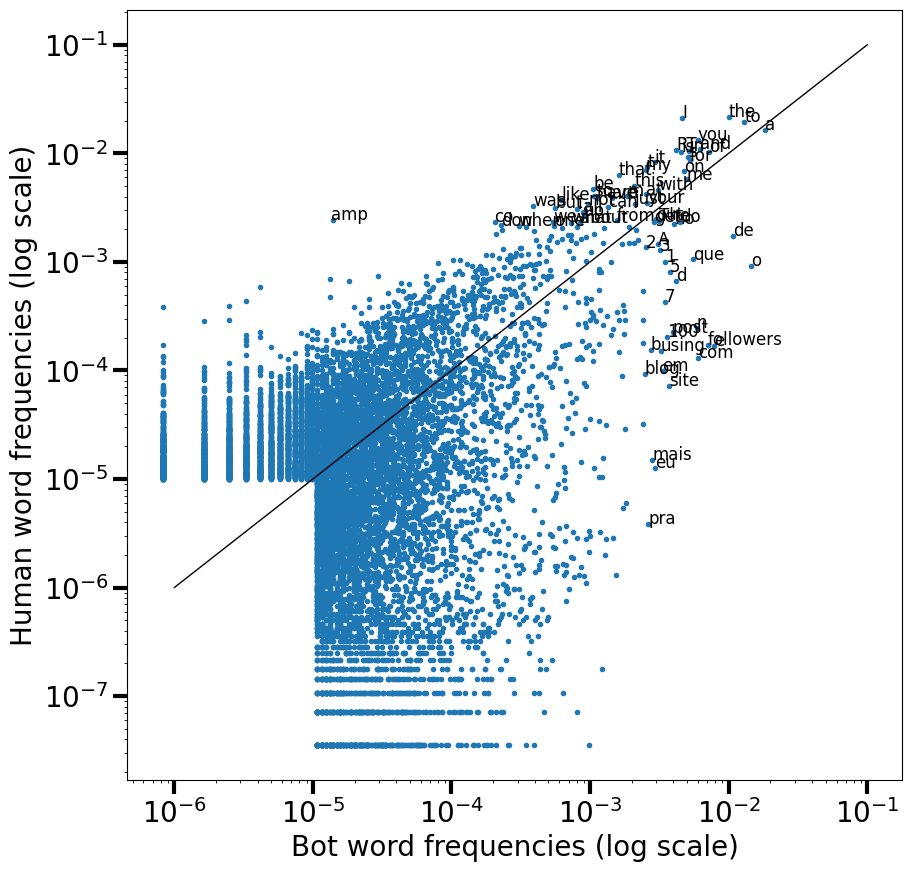

In [101]:
# Human vs Bot frequency
N_human = humans_freq.N()
N_bot = bots_freq.N()

FLT_jitter = -0.5

top_bot_words = freq_df.sort_values(by = "bot", ascending = False).iloc[0:50]["word"].values
top_human_words = freq_df.sort_values(by = "human", ascending = False).iloc[0:50]["word"].values
top_words = np.union1d(top_bot_words, top_human_words)

fig, ax = plt.subplots(figsize = (10, 10))
ax.loglog(freq_df["bot"]/N_bot, freq_df["human"]/N_human,'.')
ax.plot([1E-6,1E-1], [1E-6,1E-1], color='k', linestyle='-',linewidth = 1)
ax.set_xlabel('Bot word frequencies (log scale)')
ax.set_ylabel('Human word frequencies (log scale)')
for i in freq_df.index:
    if freq_df.loc[i,"word"] in top_words:
        ax.annotate( freq_df.loc[i,"word"], ((freq_df.loc[i, "bot"]+FLT_jitter)/bots_freq.N(), (freq_df.loc[i,"human"]+FLT_jitter)/humans_freq.N()), fontsize = 12)
        
        
plt.savefig("word_freq.png")

## Model

In [52]:
X_train, X_test, y_train, y_test = train_test_split(token_df, labels.values.ravel(), test_size = 0.5)

In [53]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [54]:
nb.score(X_train, y_train), nb.score(X_test, y_test)

(0.8485139022051774, 0.8322147651006712)

In [55]:
print(metrics.classification_report(y_train, nb.predict(X_train)))
# recall of positive class is sensitivity; recall of negative is specificity

              precision    recall  f1-score   support

         bot       0.96      0.71      0.82       496
       human       0.79      0.97      0.87       547

    accuracy                           0.85      1043
   macro avg       0.87      0.84      0.84      1043
weighted avg       0.87      0.85      0.85      1043



In [56]:
print(metrics.classification_report(y_test, nb.predict(X_test)))

              precision    recall  f1-score   support

         bot       0.94      0.70      0.80       505
       human       0.77      0.96      0.86       538

    accuracy                           0.83      1043
   macro avg       0.86      0.83      0.83      1043
weighted avg       0.85      0.83      0.83      1043



In [57]:
coef_df = pd.DataFrame({"word":token_df.columns, "coef": nb.coef_[0]})

top = coef_df.sort_values(by = "coef")[1:20]

# plt.scatter(x = top.values, y = np.abs(top.index))

/Users/alancooper/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [98]:
def plot_tuning(X_df, y):
    '''Plot coefficients for logistic regression features for varied regularization parameters.
    Also find optimum regularization parameter based on test error'''
    X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size = 0.5)

    # Regularization parameters
    alpha_range = np.arange(1e-8,1+0.1,0.01)
    
    # Accuracy
    train_acc = np.array([])
    test_acc = np.array([])
    
    for i in range(len(alpha_range)):
    
        # Logistic regression with L1 regularization
        nb = MultinomialNB(alpha = i)
        
        # logreg = make_pipeline(preprocessor, LogisticRegression(max_iter = 1000, penalty = "l1", solver = "liblinear", C = C_range[i]))

        # Fit
        nb.fit(X_train, y_train.values.ravel())
        
        # Training accuracy 
        acc = nb.score(X_train, y_train.values.ravel())
        train_acc = np.append(train_acc, acc)
        
        # Test accuracy
        acc = nb.score(X_test, y_test.values.ravel())
        test_acc = np.append(test_acc, acc)
    
    # Find optimal alpha that maximizes test accuracy
    alpha_max = alpha_range[np.argmax(test_acc)]
    
    # Plot accuracy
    plt.figure(figsize=(8,6))
    plt.plot(alpha_range, train_acc, label = "train")
    plt.plot(alpha_range, test_acc, label = "test")
    # plt.axvline(x = alpha_max, color = "r", linestyle = "dotted")
    plt.legend()
    # plt.title("Optimum smoothing parameter by testing and training accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Smoothing parameter "+r"$\alpha$")

/Users/alancooper/opt/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


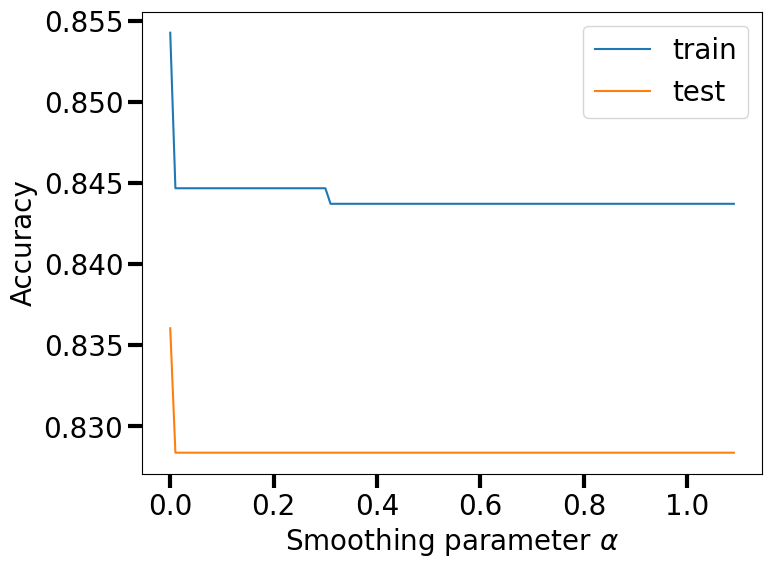

In [99]:
plot_tuning(token_df, labels)
plt.savefig("tuning.png")

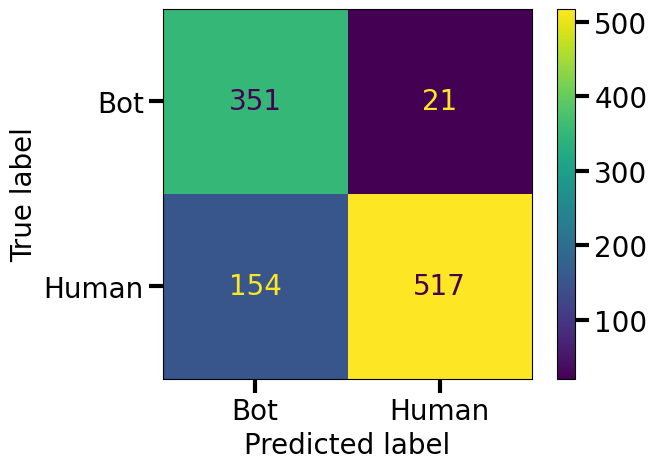

In [60]:
predictions = nb.predict(X_test)
confusion_mat = metrics.confusion_matrix(predictions, y_test)
metrics.ConfusionMatrixDisplay(confusion_mat, display_labels = ["Bot", "Human"]).plot()
plt.savefig("confusion_matrix.png")

In [61]:
pd.crosstab(y_test, predictions)

col_0,bot,human
row_0,,
bot,351,154
human,21,517


## Validation

Data is from https://github.com/fivethirtyeight/russian-troll-tweets

In [62]:
russia_df = pd.read_csv("IRAhandle_tweets_1.csv")

In [63]:
russia_df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


In [64]:
russia_df.shape

(243891, 21)

In [65]:
russia_df = russia_df.rename(columns = {"external_author_id":"user_id", "tweet_id":"id", "content":"text"})
russia_df = russia_df[["user_id", "id", "text"]]
russia_df["bot_or_not"] = "bot"

In [66]:
# Condense by user
russia_df = russia_df.groupby(by = "user_id").agg(lambda x: x.unique()).reset_index()

# Convert tweet column from list to text
russia_df["text"] = russia_df["text"].apply(lambda x: ''.join(x))

In [67]:
russia_df.shape

(236, 3)

In [68]:
# Pre-process
filtered_text = russia_df.apply(lambda x: preprocess_text(x["text"]), axis=1)
russia_df["text"] = filtered_text

In [69]:
# Tokenize
russia_token_df = russia_df.apply(lambda x: fun_tokenize(x["text"]), axis=1)

/Users/alancooper/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


In [70]:
russia_token_df = russia_token_df.fillna(value = 0)
russia_labels = russia_df["bot_or_not"]

In [71]:
russia_token_df

,0,1,10,100,2,2010,3,4,5,7,...,we,what,when,who,will,with,would,www,you,your
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
2,7.0,17.0,11.0,10.0,23.0,2.0,15.0,7.0,8.0,7.0,...,1.0,0.0,0.0,1.0,0.0,8.0,1.0,0.0,11.0,3.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,3.0,118.0,39.0,68.0,108.0,3.0,39.0,44.0,46.0,32.0,...,549.0,330.0,206.0,391.0,891.0,1797.0,262.0,0.0,1189.0,693.0
232,4.0,242.0,63.0,159.0,251.0,0.0,139.0,155.0,77.0,70.0,...,555.0,373.0,245.0,470.0,541.0,1099.0,250.0,0.0,1430.0,455.0
233,0.0,4.0,0.0,1.0,5.0,1.0,5.0,2.0,1.0,1.0,...,37.0,13.0,4.0,34.0,27.0,40.0,14.0,0.0,52.0,18.0
234,0.0,6.0,2.0,1.0,3.0,0.0,0.0,3.0,4.0,5.0,...,26.0,5.0,12.0,11.0,11.0,17.0,7.0,0.0,50.0,11.0


In [72]:
with open('filt_tokens.pkl', 'rb') as f:
      bots_tokens = pickle.load(f)
        
bots_tokens_order = pd.read_csv("token_df.csv").drop("bot_or_not", axis =1).columns

In [73]:
def add_missing_words(df):
    words_in_data = df.columns
    missing_words = [i for i in bots_tokens_order if i not in words_in_data]
    
    df_fix = df.copy() 
    for i in missing_words:
        df_fix[i] = np.repeat(0, df_fix.shape[0])
     
    
    # Reorder columns to order in tokens
    df_fix = df_fix[bots_tokens_order]
    return(df_fix)

In [74]:
russia_token_df = add_missing_words(russia_token_df)

In [75]:
russia_token_df.to_csv("rusian_token_df.csv", index = False)

In [76]:
nb.score(russia_token_df, russia_labels)

0.3432203389830508